# Time Series

In [1]:
from numpy import mean
from numpy import median
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from numpy import array
import matplotlib.pyplot as plt
import random


# Methods

In [2]:
#train_test_split([1,2,3,4,5],2)
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [3]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [4]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, method, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        if method == "average":
            yhat = average_forecast(history, cfg)
        elif method == "sarima":
            yhat = sarima_forecast(history, cfg)
        elif method == "exp":
            yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return [error,predictions]

In [5]:
def grid_search(data, cfg_list, n_test, method="sarima", parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(score_model)(data, n_test, method, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, method, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    return scores

In [6]:
def score_model(data, n_test, method, cfg, debug=False):
    result = None
    predictions = None
    # convert config to a key
    key = str(cfg)
    if debug:
        result,predictions = walk_forward_validation(data, n_test, method, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
        # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result,predictions = walk_forward_validation(data, n_test, method, cfg)
        except:
            error = None
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result, predictions)

In [7]:
def find_best_solution(series,name,method="sarima",sample=False):
    data = series.values
    scores = []
    # data split
    n_test = int(len(data)*0.2) # percentage used for test
    max_length = len(data) - n_test
    print("Training size %s " % max_length)
    print("Test size %s " % n_test)

    # model configs
    if method == "sarima":
        print("Finding best solution for %s" % method)
        cfg_list = sarima_configs()
    elif method == "average":
        print("Finding best solution for %s" % method)
        cfg_list = simple_configs(max_length)
    elif method == "exp":
        print("Finding best solution for %s" % method)
        cfg_list = exp_smoothing_configs()
        data = data[:,0]
    # sample some
    if sample:
        cfg_list_rand = random.sample(cfg_list,k=25)
        while len(scores)<5:
            cfg_list_rand = random.sample(cfg_list,k=25)
            scores += grid_search(data, cfg_list_rand, n_test, method)
    else:
        # grid search
        scores = grid_search(data, cfg_list, n_test, method)
    
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])


    print('done')
    # list top 3 configs
    for cfg, error, predictions in scores[:3]:
        print(cfg, error)

    #display
    train,test = train_test_split(data,n_test)
    prediction = pd.DataFrame(list(train.flatten())+scores[0][2])
    ax = pd.DataFrame(data).plot(label="Original") # main data
    prediction.plot(ax=ax, alpha=.7, figsize=(14,7))
    # Hide grid lines
    # ax.grid(False)

    # Hide axes ticks
    #ax.set_xticks([])
    #ax.set_yticks([])
    plt.savefig("%s_%s.png" % (name,method),transparent=True)
    plt.show()

# Average Forecast 

In [8]:
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for t in ['median',"mean"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# one-step average forecast
def average_forecast(history, config):
    n, avg_type = config
    if avg_type is 'mean':
        return mean(history[-n:])
    return median(history[-n:])

# Dummy Example

Show the algorithm always one more set of the test set and let it predict the next, do so iteratively. Then compare the whole prediction to test using mean squared error.

In [9]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
data = series.values
n_test = 100
max_length = len(data) - n_test
cfg = simple_configs(max_length)[1]
train = data[:-n_test]
test = data[-n_test:]
history = [x for x in train]    
predictions = list()
for i in range(len(test)):
    yhat = average_forecast(history, cfg)
    predictions.append(yhat)
    history.append(test[i])

error = sqrt(mean_squared_error(test, predictions))
error

7.892401408950257

# SARIMA Forecast 

In [10]:
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
      enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

# Exponential Smoothing - Holt Winters

In [11]:
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def exp_smoothing_configs(seasonal=[None]): 
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

# No-Trend: Female Births

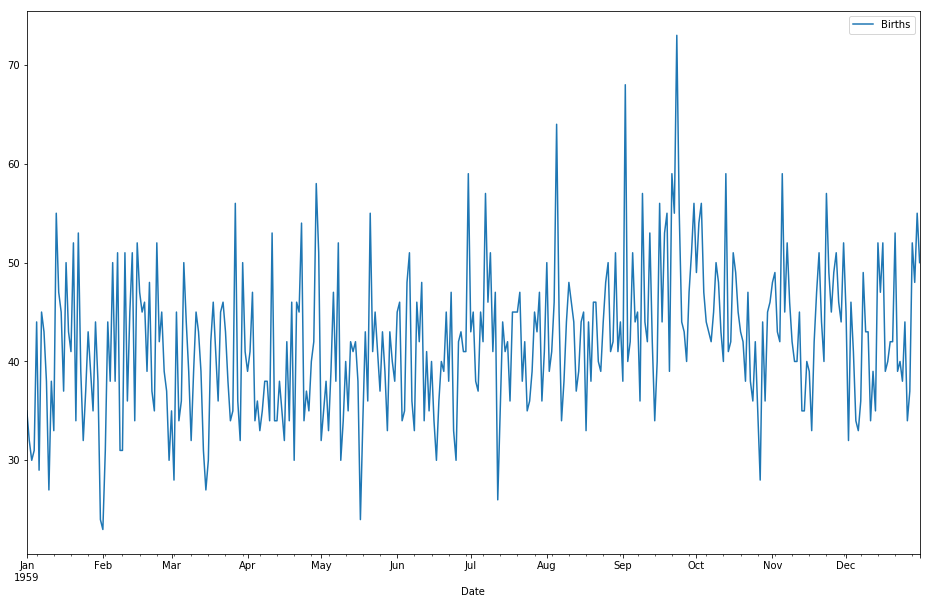

In [ ]:
series = pd.read_csv('daily-total-female-births.csv', header=0,parse_dates=["Date"],index_col=0)
#import seaborn; seaborn.set()
series.plot(figsize=(16,10))
plt.savefig('female.png',transparent=True)

In [ ]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
name = "famale-births"
find_best_solution(series,name,method="average")
find_best_solution(series,name,method="sarima")
find_best_solution(series,name,method="exp")

Training size 292 
Test size 73 
Finding best solution for average


# Trend: Shampoo Sales

In [ ]:
series = pd.read_csv('shampoo.csv', header=0)
series["Year"] = [1998]*12+[1999]*12+[2000]*12
series["Month"] = list(range(1,13))*3
series["Date"] = series["Month"].apply(str)+"-"+series["Year"].apply(str)
series['date']  = pd.to_datetime(series["Date"])
series = series[["date","Sales"]]
series.set_index(['date'],inplace=True)

import seaborn; seaborn.set()
series.plot(figsize=(16,10))
plt.savefig('shampoo.png')

In [ ]:
series = pd.read_csv('shampoo.csv', header=0, index_col=0)
name="shampoo"
find_best_solution(series,name,method="average")
find_best_solution(series,name,method="sarima")
find_best_solution(series,name,method="exp")

# Seasonality: Temp

In [ ]:
series = pd.read_csv('monthly-mean-temp.csv', header=0,parse_dates=["Month"])
series.set_index(['Month'],inplace=True)
import seaborn; seaborn.set()
series.plot(figsize=(16,10))
plt.savefig('temp.png')

In [ ]:
series = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=0)
name="temp"
find_best_solution(series,name,method="average")
find_best_solution(series,name,method="sarima")
find_best_solution(series,name,method="exp")

# Trend and Seasonality: Monthly car sales

In [ ]:
series = pd.read_csv('monthly-car-sales.csv', header=0,parse_dates=["Month"])
series.set_index(['Month'],inplace=True)
import seaborn; seaborn.set()
series.plot(figsize=(16,10))
plt.savefig('cars.png')

In [ ]:
series = pd.read_csv('monthly-car-sales.csv', header=0, index_col=0)
name="cars"
find_best_solution(series,name,method="average")
find_best_solution(series,name,method="sarima")
find_best_solution(series,name,method="exp")